In [14]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")

# import matplotlib as mpl
# mpl.rcParams['font.sans-serif'] = ['simhei']
# mpl.rcParams['font.serif'] = ['simhei']

plt.style.use("fivethirtyeight")

# from matplotlib.font_manager import FontProperties
# myfont=FontProperties(fname='/home/alan/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/simhei.ttf')
# sns.set(font=myfont.get_name())
sns.set_style({'font.sans-serif': ['simsun', 'Arial']})
sns.set_style('darkgrid', {'font.sans-serif': ['simhei', 'Arial']})
%matplotlib inline

In [15]:
df = pd.read_csv('./Data/preprocessedData.csv')
display(df.head(n=5))
len(df)

,Region,District,Garden,Layout,Floor,Year,Size,Elevator,Direction,Renovation,PerPrice,Price
0,东城,灯市口,锡拉胡同21号院,3室1厅,6,1988,75.0,无电梯,东西,精装,10.400000,780.0
1,东城,东单,东华门大街,2室1厅,6,1988,60.0,无电梯,南北,精装,11.750000,705.0
2,东城,崇文门,新世界中心,3室1厅,16,1996,210.0,有电梯,南西,其他,6.666667,1400.0
3,东城,崇文门,兴隆都市馨园,1室1厅,7,2004,39.0,有电梯,南,精装,10.769231,420.0
4,东城,陶然亭,中海紫御公馆,2室2厅,19,2010,90.0,有电梯,南,精装,11.088889,998.0


23656

## 特征工程

### Layout

In [16]:
# 只考虑“室”和“厅”，将其它少数“房间”和“卫”移除
# 原链接的代码错误，这里进行修改
# df.loc[(df['Layout'].str.extract('^\d(.*?)\d.*?') == '厅')]
# expand=False 表示返回Series，=True表示返回Dataframe
df = df.loc[(df['Layout'].str.extract('^\d(.*?)\d.*?', expand=False) == '室')]

In [17]:
# 挖掘房间数量
df['Layout_room_num'] = df['Layout'].str.extract(
    '^(\d).*?\d.*?', expand=False).astype('int64')
df['Layout_hall_num'] = df['Layout'].str.extract(
    '^\d.*?(\d).*?', expand=False).astype('int64')

### Year

In [18]:
# Year属于连续型数值，如果每个年份都作为特征处理，可能出现过拟和，因此要将year离散化，这里使用分箱处理
# 等距分箱处理
df['Year'] = pd.qcut(df['Year'], 8).astype('object')

### Direction

In [19]:
df['Direction'].value_counts()

南北        11367
南          2726
东西         1388
东南         1311
西南         1094
东           843
西           802
西北          733
东北          645
北           484
东南北         465
南西北         370
南西          158
东西北         139
东南西         133
西南北         124
东南西北         90
西南东北         23
南东北          19
东南西南         15
东南南          13
西东北          10
西南西北         10
东东南          10
东西南           9
南西南           9
东南东北          7
东南南北          5
西南西           5
南西东北          3
东西南北          3
东北东北          2
西北东北          2
南东            2
南西北北          2
南西南西          2
南西南北          2
南西西北          2
东东北           2
西北北           2
西西北           2
西西南           2
北南            1
南北西           1
西南西北北         1
东南西北北         1
东东南南          1
北西            1
南北东           1
南北东北          1
东南西南北         1
东南北西          1
东西北东北         1
西南西北东北        1
东南西南东北        1
东西北北          1
东南南西北         1
东西东北          1
东南西北东北        1
Name: Direction, dtype: int64

In [20]:
# 写函数 direct_func 来整理上面较乱的 Direction
def direct_func(x):
    if not isinstance(x, str):
        raise TypeError
    x = x.strip()
    x_len = len(x)
    x_list = pd.unique([y for y in x])
    if x_len != len(x_list):
        return 'no'

    if (x_len == 2) & (x not in d_list_two):
        m0 = x[0]
        m1 = x[1]
        return m1+m0
    elif (x_len == 3) & (x not in d_list_three):
        for n in d_list_three:
            if (x_list[0] in n) & (x_list[1] in n) & (x_list[2] in n):
                return n
    elif (x_len == 4) & (x not in d_list_four):
        return d_list_four[0]
    else:
        return x

In [21]:
# 通过 apply() 方法将 Direction 数据格式转换
d_list_one = ['东', '西', '南', '北']
d_list_two = ['东西', '东南', '东北', '西南', '西北', '南北']
d_list_three = ['东西南', '东西北', '东南北', '西南北']
d_list_four = ['东西南北']
df['Direction'] = df['Direction'].apply(direct_func)
df = df.loc[(df['Direction'] != 'no') & (df['Direction'] != 'nan')]

df['Direction'].value_counts()

南北      11368
南        2726
东西       1388
东南       1313
西南       1252
东         843
西         802
西北        734
东北        645
西南北       495
东南北       485
北         484
东西北       149
东西南       142
东西南北      120
Name: Direction, dtype: int64

### 创建新特征

有时候仅靠已有的一些特征是不够的，***需要根据对业务的理解***，定义一些的新特征，然后尝试这些新特征对模型的影响，在实战中会经常使用这种方法。
这里尝试将"室"与"厅"的数量相加作为一个总数量特征，然后将房屋大小Size与总数量的比值作为一个新特征，可理解为 "每个房间的平均面积大小"。当然，新特征不是固定的，***可根据自己的理解来灵活的定义***。

In [22]:
df['Layout_total_num'] = df['Layout_room_num']+df['Layout_hall_num']
df['Size_room_ratio'] = df['Size']/df['Layout_total_num']

In [23]:
# 删除无用特征
df = df.drop(['Layout', 'PerPrice', 'Garden', 'District'], axis=1)

In [24]:
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [25]:
df, df_cat = one_hot_encoder(df)
display(df.head(n=3))
df_cat

,Floor,Size,Price,Layout_room_num,Layout_hall_num,Layout_total_num,Size_room_ratio,Region_东城,Region_丰台,Region_亦庄开发区,...,Direction_西,Direction_西北,Direction_西南,Direction_西南北,Direction_nan,Renovation_其他,Renovation_毛坯,Renovation_简装,Renovation_精装,Renovation_nan
0,6,75.0,780.0,3,1,4,18.75,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,6,60.0,705.0,2,1,3,20.00,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,16,210.0,1400.0,3,1,4,52.50,1,0,0,...,0,0,1,0,0,1,0,0,0,0


['Region_东城',
 'Region_丰台',
 'Region_亦庄开发区',
 'Region_大兴',
 'Region_密云',
 'Region_平谷',
 'Region_怀柔',
 'Region_房山',
 'Region_昌平',
 'Region_朝阳',
 'Region_海淀',
 'Region_石景山',
 'Region_西城',
 'Region_通州',
 'Region_门头沟',
 'Region_顺义',
 'Region_nan',
 'Year_(1949.999, 1990.0]',
 'Year_(1990.0, 1997.0]',
 'Year_(1997.0, 2000.0]',
 'Year_(2000.0, 2003.0]',
 'Year_(2003.0, 2004.0]',
 'Year_(2004.0, 2007.0]',
 'Year_(2007.0, 2010.0]',
 'Year_(2010.0, 2017.0]',
 'Year_nan',
 'Elevator_无电梯',
 'Elevator_有电梯',
 'Elevator_nan',
 'Direction_东',
 'Direction_东北',
 'Direction_东南',
 'Direction_东南北',
 'Direction_东西',
 'Direction_东西北',
 'Direction_东西南',
 'Direction_东西南北',
 'Direction_北',
 'Direction_南',
 'Direction_南北',
 'Direction_西',
 'Direction_西北',
 'Direction_西南',
 'Direction_西南北',
 'Direction_nan',
 'Renovation_其他',
 'Renovation_毛坯',
 'Renovation_简装',
 'Renovation_精装',
 'Renovation_nan']

<p>这部分是 One-hot 独热编码，因为像 Region，Year（离散分箱后），Direction，Renovation，Elevator等特征都是定类的非数值型类型，而作为模型的输入我们需要将这些非数值量化。</p>

<p>在没有一定顺序（定序类型）的情况下，使用独热编码处理定类数据是非常常用的做法，在pandas中非常简单，就是使用 get_dummies() 方法，而对于像Size这样的定比数据则不使用独热，博主这里用了一个自己封装的函数实现了定类数据的自动量化处理。</p>

### 特征相关性

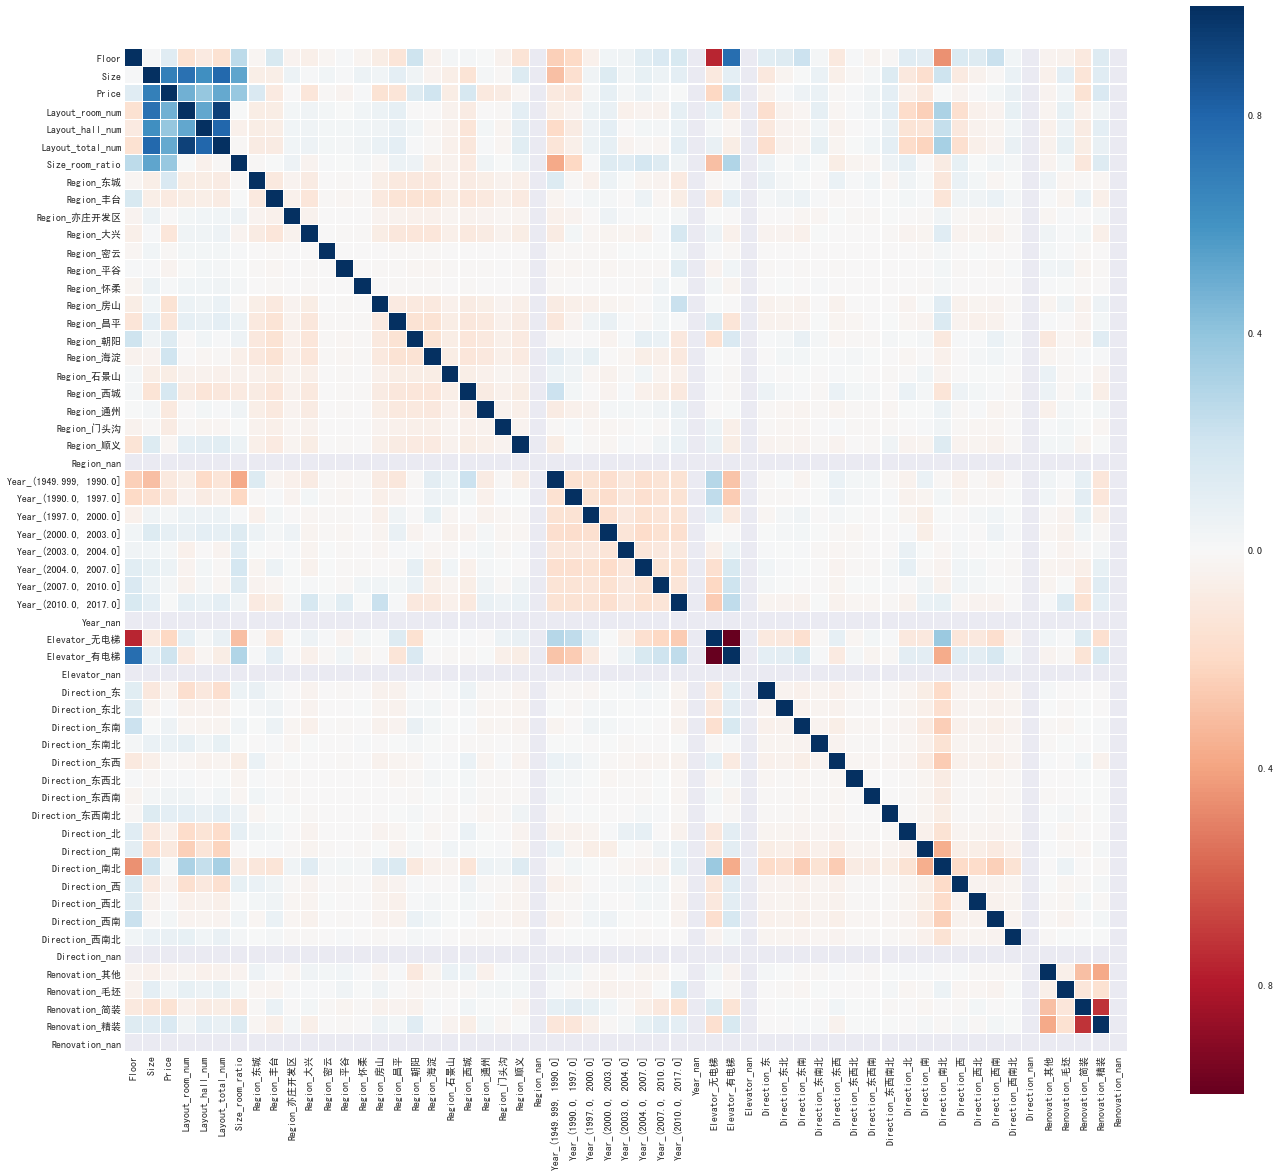

In [26]:
colormap = plt.cm.RdBu
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(),
            linewidths=0.1,
            vmax=1.0,
            square=True,
            cmap=colormap,
            linecolor='white',
            annot=False)

颜色偏红或者偏蓝都说明相关系数较大，即两个特征对于目标变量的影响程度相似，即存在严重的重复信息，会造成过拟合现象。因此，通过特征相关性分析，我们可以找出哪些特征有严重的重叠信息，然后择优选择。

## 建模预测

In [30]:
# 特征变量和目标变量
features = df.drop('Price', axis=1)
prices = df['Price']

# 把分类特征都转成数值型后有{}行{}列
print('北京二手房房价有数据 {0} 条，字段 {1} 个' .format(*df.shape))

北京二手房房价有数据 22946 条，字段 57 个


In [31]:
# 将数据集划分为训练集与测试集
from sklearn.model_selection import train_test_split
features = np.array(features)
prices = np.array(prices)
# 导入 sklearn 进行训练测试集划分

features_train, features_test, prices_train, prices_test = train_test_split(features,
                                                                            prices,
                                                                            test_size=0.2,
                                                                            random_state=0)

In [32]:
# 建立模型
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# 通过交叉认证缓解数据集过拟合的现象
# 建立决策树回归模型
# 通过GridSearchCV找到最优深度参数（基于输入数据[X,y] 利于网格搜索找到最优的决策树模型）


def fit_model(X, y):

    cross_validator = KFold(10, shuffle=True)
    regressor = DecisionTreeRegressor()
    params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
    scoring_fnc = make_scorer(performance_metric)
    grid = GridSearchCV(estimator=regressor, param_grid=params,
                        scoring=scoring_fnc, cv=cross_validator)

    # 网格搜索
    grid = grid.fit(X, y)
    return grid.best_estimator_

In [34]:
# 计算 R2 分数
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    score = r2_score(y_true, y_predict)
    
    return score
    
# 调参优化模型
# 通过可视化模型学习曲线，观察是否出现过拟合问题
# visuals 为自定义函数
# import visuals as vs

# 分析模型
# vs.ModelLearning(features_train, prices_train)
# vs.ModelComplexity(features_train, prices_train)
optimal = fit_model(features_train, prices_train)

# 输出最优模型的参数 'max_depth'
print('最优模型的参数 max_depth 是: {} ' .format(optimal.get_params()['max_depth']))

predicted_value = optimal.predict(features_test)
r2 = performance_metric(prices_test, predicted_value)

# 每次交叉验证得到的数据集不同，因此每次运行的结果也不一定相同
print('最优模型在测试数据上 R^2 分数 {: .2f}' .format(r2))

AttributeError: module 'visuals' has no attribute 'ModelLearning'